In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import glob
from PIL import Image
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Dataset taken from:
https://www.kaggle.com/ankitesh97/pokemon-images/version/1

In [8]:
df = pd.read_csv('mnist/fashion-mnist_test.csv')
mnist = pd.read_csv('mnist/digits.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
data = mnist.iloc[:, 1:].values.reshape(-1, 28, 28)
#data = mnist.values.reshape(-1, 28, 28)
print(data.shape)
dataset_size = data.shape[0]
width = data.shape[1]
height = data.shape[2]

(10000, 28, 28)


<IPython.core.display.Javascript object>


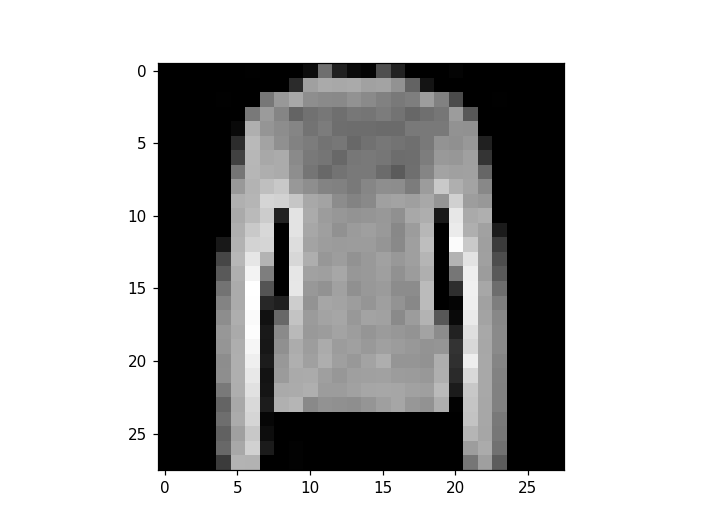

In [63]:
plt.imshow(data[22], cmap='gray')
plt.show()

In [7]:
def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()

    im = [OffsetImage(i, zoom=zoom, cmap='gray') for i in images]
    x, y = np.atleast_1d(x, y)
    artists = []
    
    for x0, y0, i in zip(x, y, im):
        ab = AnnotationBbox(i, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [64]:
def plot_random(x, y, images, n, zoom):
    size = len(images)
    
    indices = np.random.choice(np.arange(size), n, replace=False)
    x_sample = x[indices]
    y_sample = y[indices]
    img_sample = images[indices]
    
    return imscatter(x_sample, y_sample, img_sample, zoom=zoom)

<IPython.core.display.Javascript object>


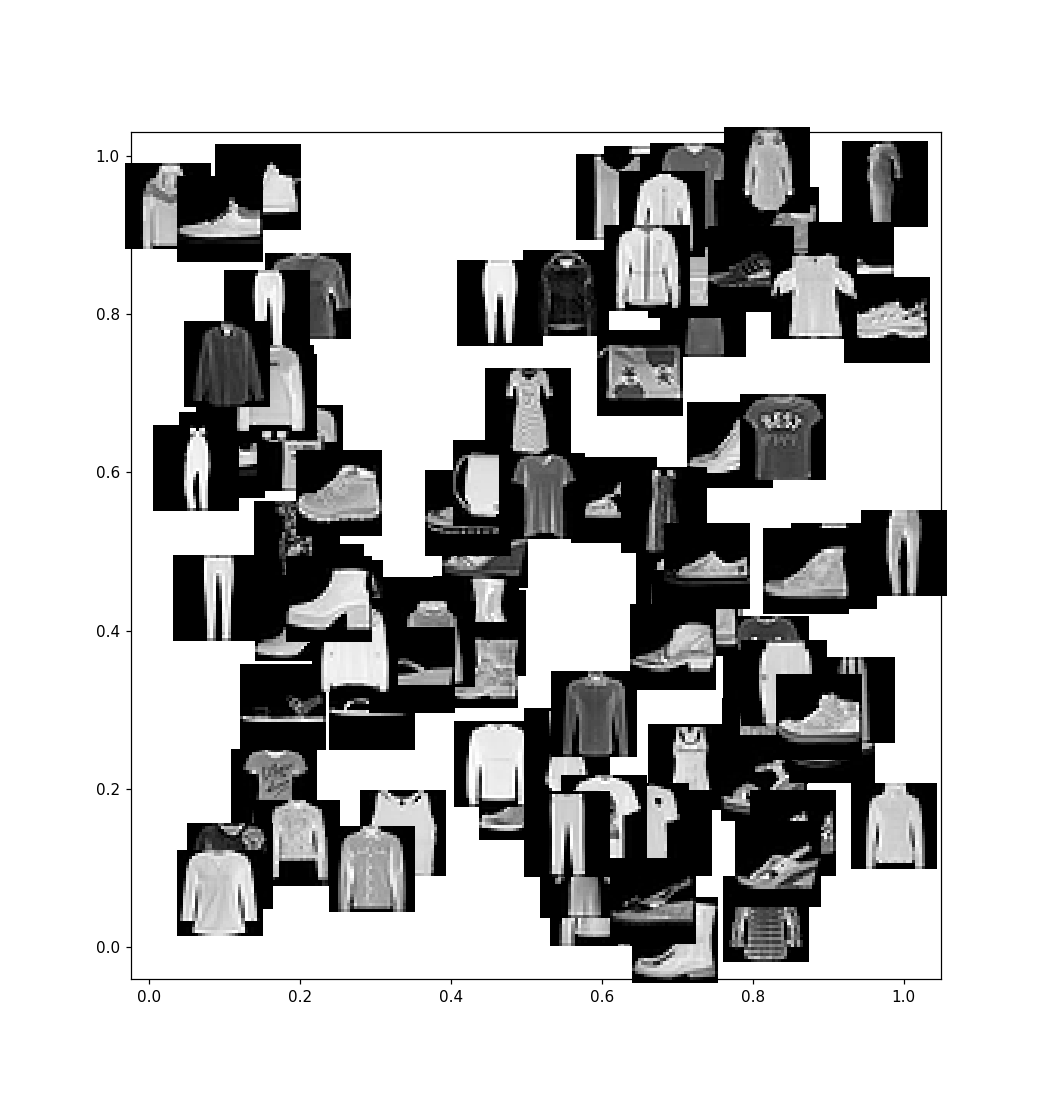

In [65]:
plt.figure(figsize=(9.5, 10))
fig = plot_random(
    np.random.rand(dataset_size),
    np.random.rand(dataset_size),
    data[:dataset_size],
    100,
    zoom=2)
plt.show()

In [11]:
flat_data = data.reshape(-1, width*height)
scaled_data = StandardScaler().fit_transform(flat_data)

scaled_data.shape

/home/mateusz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mateusz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(28000, 784)

In [66]:
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_data)
comp_df = pd.DataFrame(data=comp)
comp_df.head()

,0,1
0,11.748825,-4.444502
1,18.395311,-0.997854
2,-5.250491,-0.300171
3,-3.200058,-0.589613
4,-1.764211,-1.881635


<IPython.core.display.Javascript object>


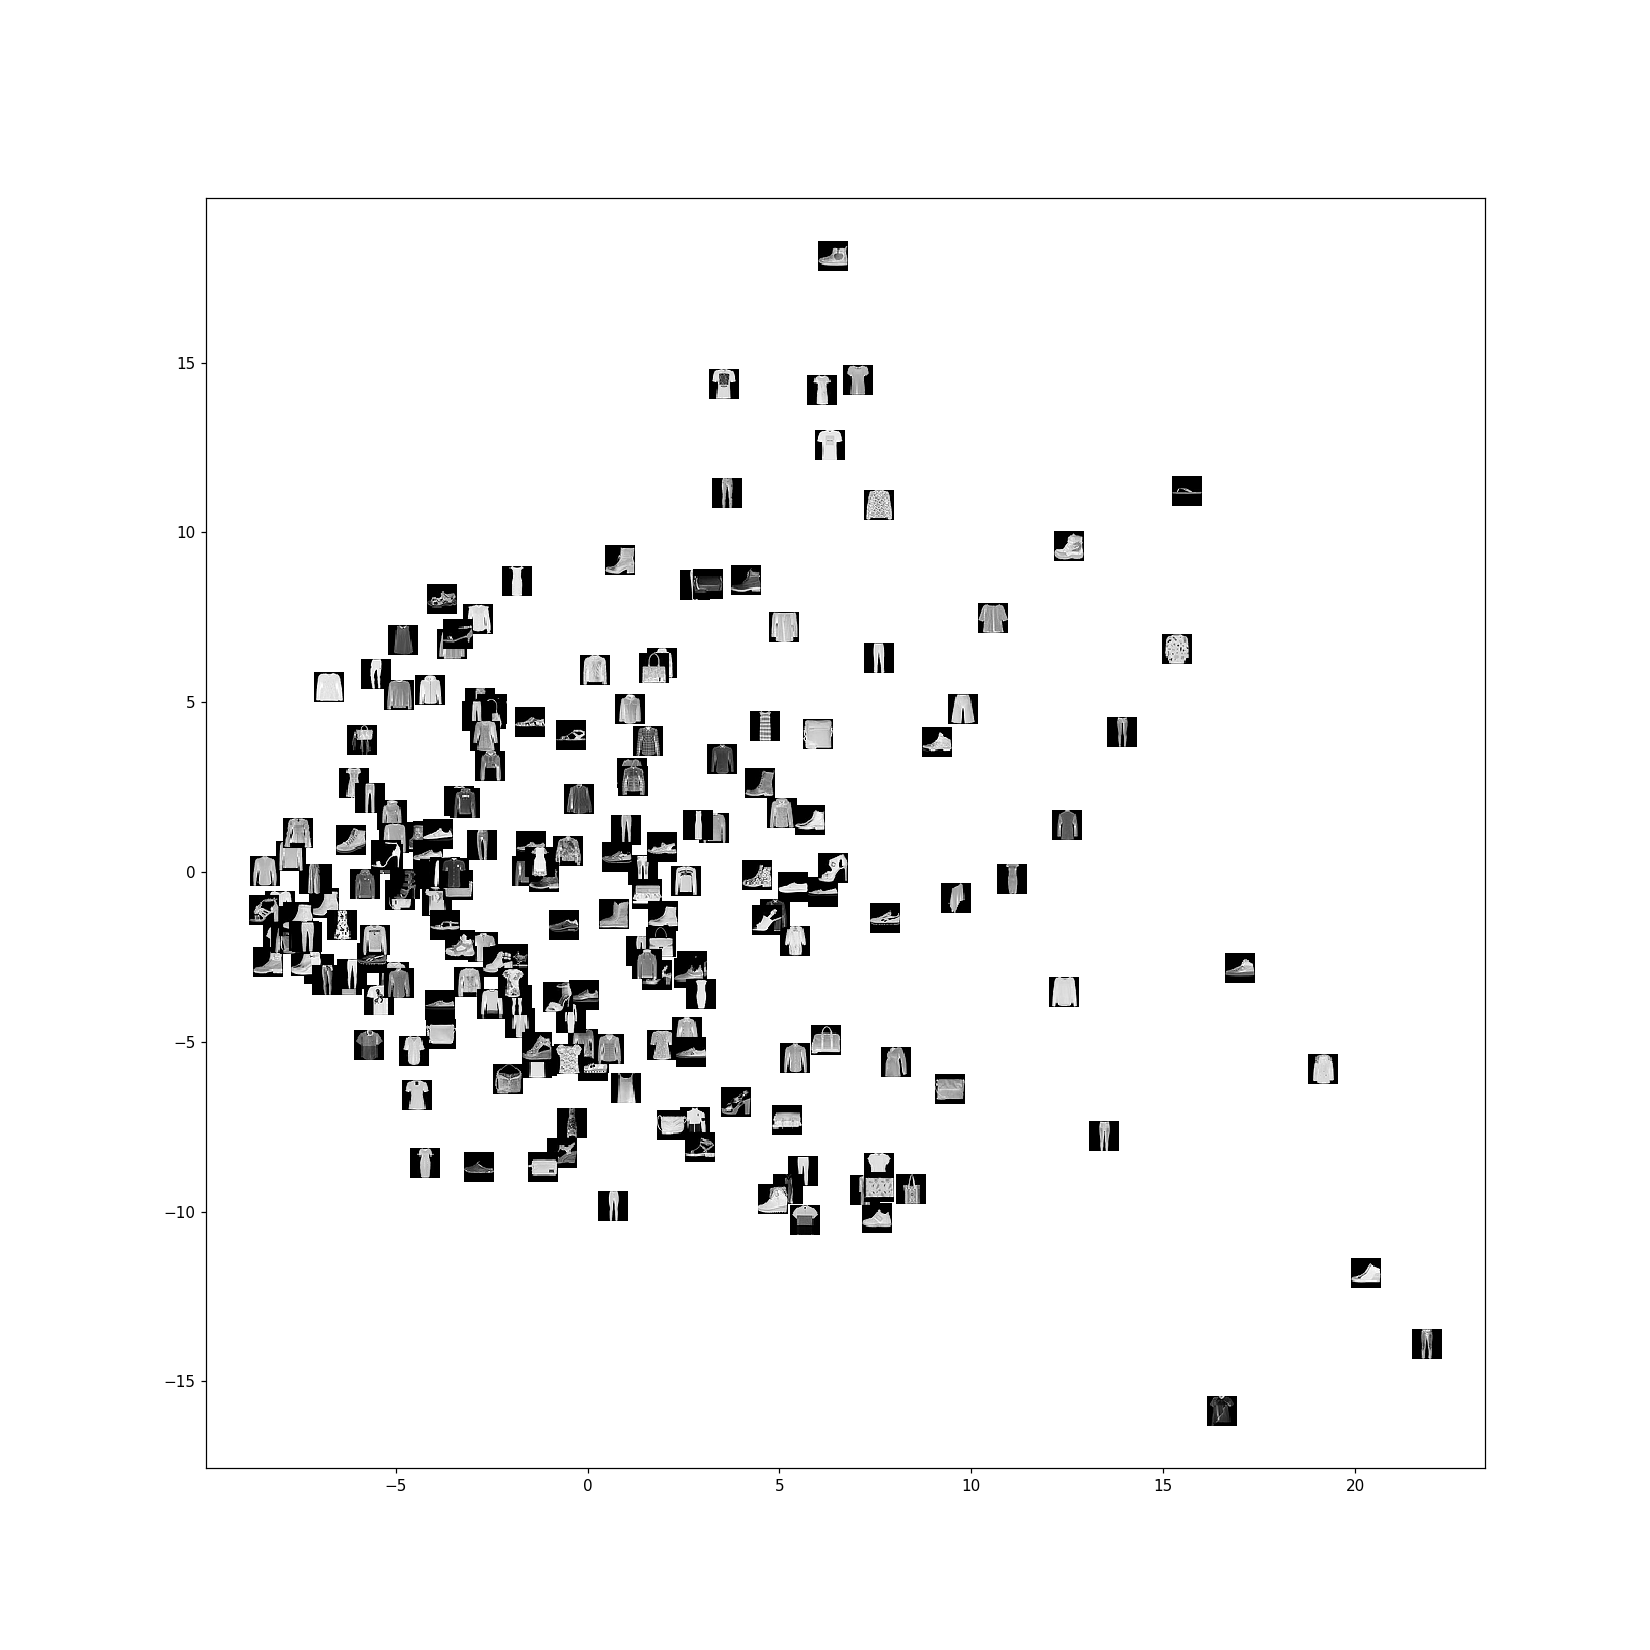

In [67]:

plt.figure(figsize=(15, 15))
fig = plot_random(
    comp_df[0],
    comp_df[1],
    data,
    200,
    zoom=0.7)

In [68]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.00008)
comp = kpca.fit_transform(scaled_data[:3000])
comp_df = pd.DataFrame(data=comp)
comp_df.head()

,0,1
0,0.128915,-0.066224
1,0.210582,-0.058302
2,-0.064812,0.006391
3,-0.042117,-0.003985
4,-0.032724,-0.018108


In [74]:
%matplotlib notebook

kpca = KernelPCA(n_components=2, kernel='rbf')
comp = kpca.fit_transform(scaled_data)
comp_df = pd.DataFrame(data=comp)
comp_df.head()


plt.figure(figsize=(9.5, 10))
fig = plot_random(
    comp_df[0],
    comp_df[1],
    data[:1000],
    500,
    zoom=0.7)

KeyboardInterrupt: 

In [41]:
def display_scree_plot(data, kernel=False, number_of_components=None, percentage=True, gamma=None):  
    # scaling data so that every gene has similar weight
    scaler = StandardScaler()
    with warnings.catch_warnings(record=True):
        scaled_data = scaler.fit_transform(data)
    
    if kernel:
        kpca = KernelPCA(kernel="rbf", gamma=gamma)
        kpca.fit_transform(scaled_data)
        bar_heights = kpca.lambdas_
        if percentage:
            sum_of_variances = sum(bar_heights)
            bar_heights = list(map(lambda x: x * 100 / sum_of_variances, bar_heights[:number_of_components]))
            plt.ylabel("[%]")
    else:
        pca = PCA(n_components=number_of_components)
        components = pca.fit_transform(scaled_data)
        if percentage:
            bar_heights = pca.explained_variance_ratio_
            bar_heights = list(map(lambda x: x * 100, bar_heights))
            plt.ylabel("[%]")
        else:
            bar_heights = pca.explained_variance_
        

    bar_x_coordinates = np.array(range(len(bar_heights)))
    labels = ['PC ' + str(i) for i in range(1, len(bar_heights) + 1)]
    
    plt.bar(bar_x_coordinates, bar_heights, tick_label=labels)
    plt.show()
    return
    

<IPython.core.display.Javascript object>


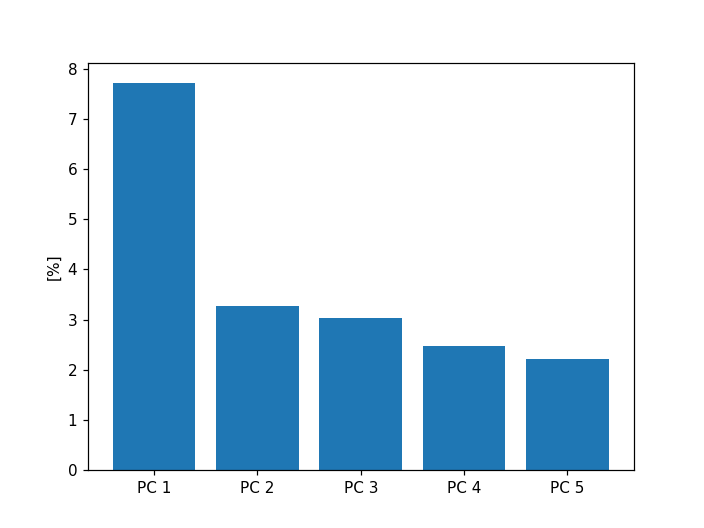

In [71]:
import warnings
display_scree_plot(flat_data[:1000], kernel=True, number_of_components=5)

In [165]:
kpca = KernelPCA(n_components=2, kernel='rbf')
comp = kpca.fit_transform(scaled_edges)
comp_df = pd.DataFrame(data=comp, columns=['pc1', 'pc2'])
comp_df.head()

,pc1,pc2
0,-0.009310,0.093325
1,-0.018633,0.042961
2,0.078798,0.049105
3,-0.071694,0.052726
4,-0.054769,0.026893


<IPython.core.display.Javascript object>


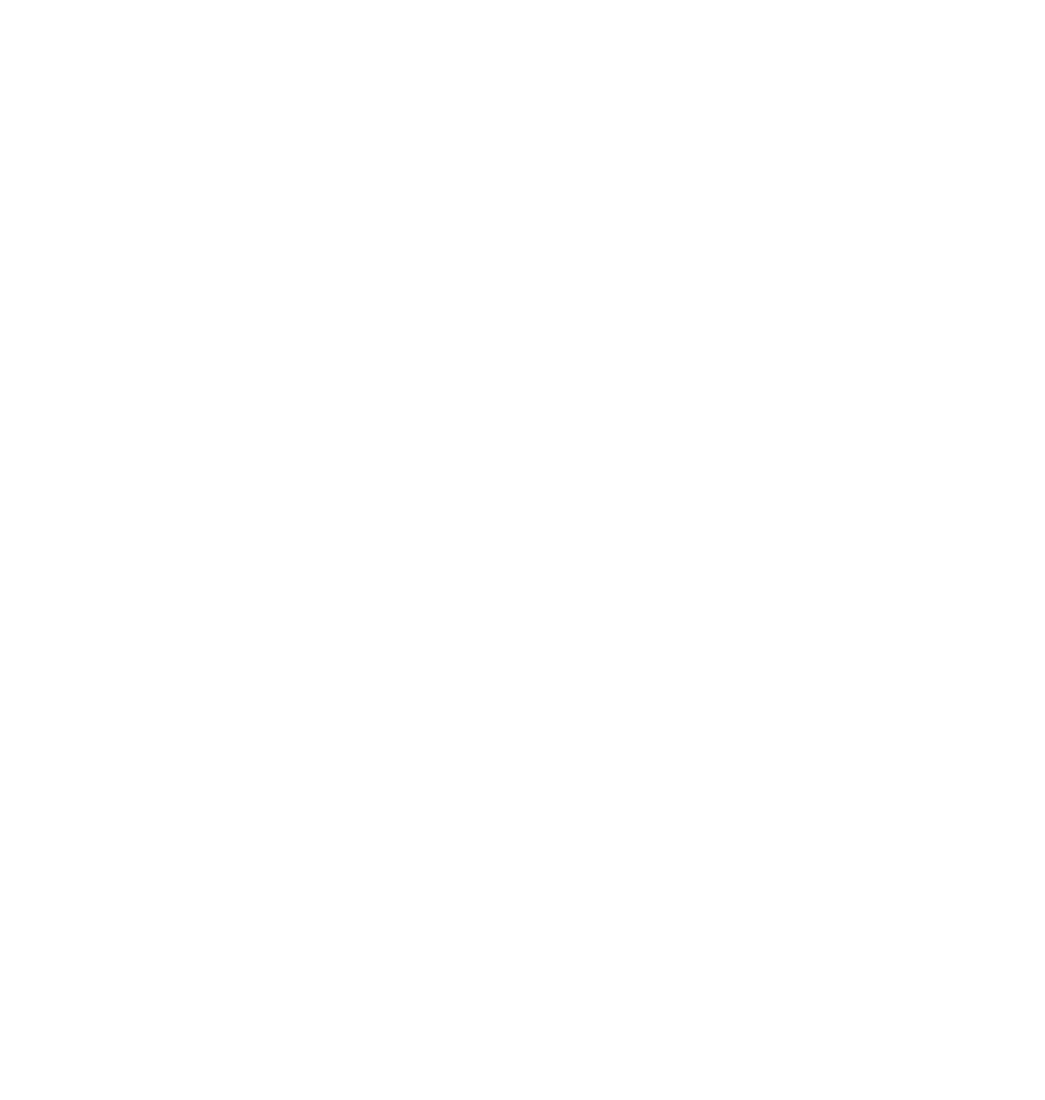

KeyError: 'pc1'

In [15]:
%matplotlib notebook
plt.figure(figsize=(9.5, 10))
fig = plot_random(
    comp_df['pc1'],
    comp_df['pc2'],
    edges,
    200,
    zoom=0.7)

In [16]:
fig = plot_nearest(comp_df.values[22], comp_df.values, data, 10, (5, 2))

NameError: name 'plot_nearest' is not defined

In [17]:
def plot_nearest(origin, data, images, n, shape):
    
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='brute').fit(data)
    distances, indices = nbrs.kneighbors(np.atleast_2d(origin))
    
    print(indices)
    
    fig, axes = plt.subplots(shape[0], shape[1])
    axes = axes.flatten()
    
    for i, img in enumerate(images[indices.flatten()]):
        axes[i].imshow(img)
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    return fig

In [18]:
comp_df.values

array([[ 15.89695975,  -4.20823986],
       [ -1.14655528, -17.44520114],
       [ -9.79242003,  -3.20734022],
       ...,
       [  4.29646676,  10.41309483],
       [ 19.5213348 ,  18.29732467],
       [ 22.45732003,  -0.85621212]])

In [19]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute').fit(comp_df.values)
distances, indices = nbrs.kneighbors(np.atleast_2d(comp_df.values[0]))

[[ 499 6861  426   99 4128 2150 3894 7271 6488 8457]]


<IPython.core.display.Javascript object>


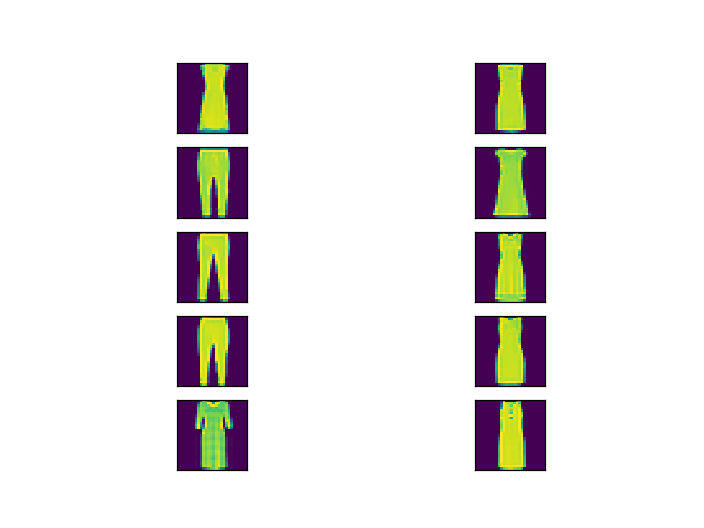

In [20]:
fig = plot_nearest(comp_df.values[499], comp_df.values, data, 10, (5, 2))